In [1]:
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import numpy as np 
import pandas as pd 

import gc
import datetime
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
##### Functions 

# 1st function: Adds number of ocurrences to the column element to see if it is a frequent value or not.
def frecuency_encoder(cols, df_train, df_test):
    for col in cols:
        temp = df_train[col].value_counts().to_dict()
        df_train[f'{col}_counts'] = df_train[col].map(temp).astype('float32')
        
        temp = df_test[col].value_counts().to_dict()
        df_test[f'{col}_counts']  = df_test[col].map(temp).astype('float32')

# 2nd function : creates a list of statistics (in aggregations) to be applied to a list of columns, given to group specified by group.
def aggregations(cols, group, aggregations, df_train, df_test):
    for col in cols:
        for aggr in aggregations:
            temp     = df_train.groupby([group])[col].agg([aggr])
            dict_aux = temp[aggr].to_dict()
            df_train[f'{col}_{aggr}'] = df_train[group].map(dict_aux).astype('float32')
            
            temp     = df_test.groupby([group])[col].agg([aggr])
            dict_aux = temp[aggr].to_dict()
            df_test[f'{col}_{aggr}'] = df_test[group].map(dict_aux).astype('float32')   

In [3]:
##### Download of files.

print('Downloading datasets...')
print(' ')
train = pd.read_pickle('/kaggle/input/ieee-cis-preprocessing/train.pkl')
print('Train has been downloaded... (1/2)')
test = pd.read_pickle('/kaggle/input/ieee-cis-preprocessing/test.pkl')
print('Test has been downloaded... (2/2)')
print(' ')
print('All files are downloaded')

 
Train has been downloaded... (1/2)
Test has been downloaded... (2/2)
 
All files are downloaded


In [4]:
##### Additional Preprocessing
# Filling NaNs. Does not change engineered Ds with negatives (-9999).
# Rest of the columns model worked better with Nan -> -1 than -999.

fill_nan_exceptions = ['D1achr', 'D2achr', 'D4achr', 'D6achr', 'D10achr', 'D11achr', 'D12achr', 'D13achr', 'D14achr', 'D15achr']

fill_nan = list(train.columns)
fill_nan.remove('isFraud')

for col in fill_nan_exceptions:
    fill_nan.remove(col)
    
train[fill_nan] = train[fill_nan].replace(np.nan, -1)
test[fill_nan]  = test[fill_nan].replace(np.nan, -1)

train[fill_nan_exceptions] = train[fill_nan_exceptions].replace(np.nan, -9999)
test[fill_nan_exceptions]  = test[fill_nan_exceptions].replace(np.nan, -9999) 

In [5]:
##### Feature Engineering
frecuency_encoder(['card1', 'card2','D1achr','addr1'], train, test)

In [6]:
##### Feature selection for the model

feature_list = list(train.columns)

# Remove overfitting. Target - original engineered Ds from model features

remove_features = ['TransactionID', 'isFraud', 'TransactionDT', 'uid1', 'uid2', 'uids', 
                   'DT', 'D1', 'D2', 'D4', 'D6', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

# Remove less important features (from feature importance results)

worst_features = ['V150', 'V48', 'V164', 'D5', 'V125', 'V277', 'V182', 'D7', 'V271', 'V261', 'V196', 'V168', 
                  'V275', 'V5', 'V114', 'V132', 'V339', 'V250', 'V219', 'V103', 'V37', 'V307', 'V213', 'V186',
                  'V105', 'V297', 'V291', 'V9', 'V278', 'V221', 'V214', 'dist2', 'V303', 'V180', 'V270', 'V98',
                  'V304', 'V238', 'V290', 'V215', 'V306', 'V192', 'V236', 'V255', 'V130', 'V3', 'V46', 'V7',
                  'V260', 'V212', 'V185', 'V319', 'V237', 'V120', 'V203', 'V101', 'V191', 'V247', 'V269', 'V273',
                  'V157', 'V8', 'V167', 'V228', 'V127', 'V316', 'V4', 'M1', 'V84', 'V222', 'V128', 'V226', 'V116',
                  'V177', 'V134', 'V276', 'V263', 'D9', 'V264', 'V176', 'V6', 'V265', 'V126', 'V199', 'V183', 'V202',
                  'V211', 'V240', 'V218', 'V11', 'V302', 'V135', 'V204', 'V229', 'V292', 'V328', 'V230', 'V2', 'V122',
                  'V10', 'V95', 'V96', 'V190', 'V104', 'V118', 'V97', 'V181', 'V1', 'V41', 'V117', 'V119', 'V28',
                  'V65', 'V107', 'V305', 'V68', 'V27', 'V241', 'V89']

# Get the feature list

remove_features.extend(worst_features)

for feat in remove_features:
    try:
        feature_list.remove(feat)
    except:
        pass

print('Columns selected:', feature_list)
print('Length:', len(feature_list))

# Get target
target = 'isFraud'

Columns selected: ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D3', 'D8', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V47', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V85', 'V86', 'V87', 'V88', 'V90', 'V91', 'V92', 'V93', 'V94', 'V99', 'V100', 'V102', 'V106', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V115', 'V121', 'V123', 'V124', 'V129', 'V131', 'V133', 'V136', 'V137', 'V138', 'V139', 'V140', 

In [7]:
##### Train + val separation
# Train: days 1  to 150 (5 months)
# Test: days  150 to the end (1 month)

df_train = train.query('DT <= 150') 
df_val  = train.query('DT >  150')

# Modelling with XGBoost

In [8]:
##### XGBoosting

clf = xgb.XGBClassifier(
                objective = 'binary:logistic', 
                base_score = 0.5, 
                booster = 'gbtree', 
                colsample_bylevel = 1,
                colsample_bynode = 1,
                colsample_bytree = 0.4,     #percentage of columns by tree, overfitting parameter
                gamma = 0,
                gpu_id = -1,
                importance_type = 'gain',
                interaction_constraints = '',
                learning_rate = 0.02,
                max_delta_step = 0,
                max_depth = 12,             #max tree depth, overfitting parameter
                min_child_weight = 1,
                missing = -1,               #missing value is the value to replace NaN. Default, np.nan
                monotone_constraints =(),
                n_estimators = 2000,        #number of trees. 
                n_jobs = 0,
                num_parallel_tree = 1,
                random_state = 0,
                reg_alpha = 0, 
                reg_lambda = 1,
                scale_pos_weight = 1,
                subsample = 0.8,            #percentage of rows by tree, overfitting parameter
                tree_method = 'gpu_hist',   #use gpu to speed the training/fit of the model.
                validate_parameters = 1,
                verbosity = None,           #verbosity (0-3) O is silent, and 3 debug. It looks this does not impact in verbose.
                eval_metric = 'auc')

clf.fit(df_train[feature_list], df_train[target], 
eval_set=[(df_train[feature_list],   df_train[target]), (df_val[feature_list],   df_val[target])],
        verbose=100, early_stopping_rounds=100)

[0]	validation_0-auc:0.82953	validation_1-auc:0.81996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.92743	validation_1-auc:0.89124
[200]	validation_0-auc:0.96695	validation_1-auc:0.91693
[300]	validation_0-auc:0.98502	validation_1-auc:0.93178
[400]	validation_0-auc:0.99220	validation_1-auc:0.93782
[500]	validation_0-auc:0.99481	validation_1-auc:0.93865
[600]	validation_0-auc:0.99616	validation_1-auc:0.93868
Stopping. Best iteration:
[507]	validation_0-auc:0.99492	validation_1-auc:0.93879



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=-1,
              monotone_constraints=(), n_estimators=2000, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [9]:
##### AUC

auc = clf.best_score
print('AUC:',auc) 

AUC: 0.938792


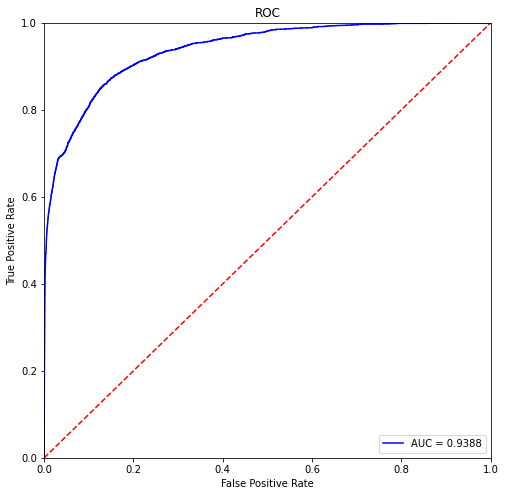

In [10]:
##### ROC Curve
y_pred_valid = clf.predict_proba(df_val[feature_list])
r_curve = roc_curve(df_val[target].values, y_pred_valid[:,1])


plt.figure(figsize=(8,8))
plt.title('ROC')
plt.plot(r_curve[0], r_curve[1], 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

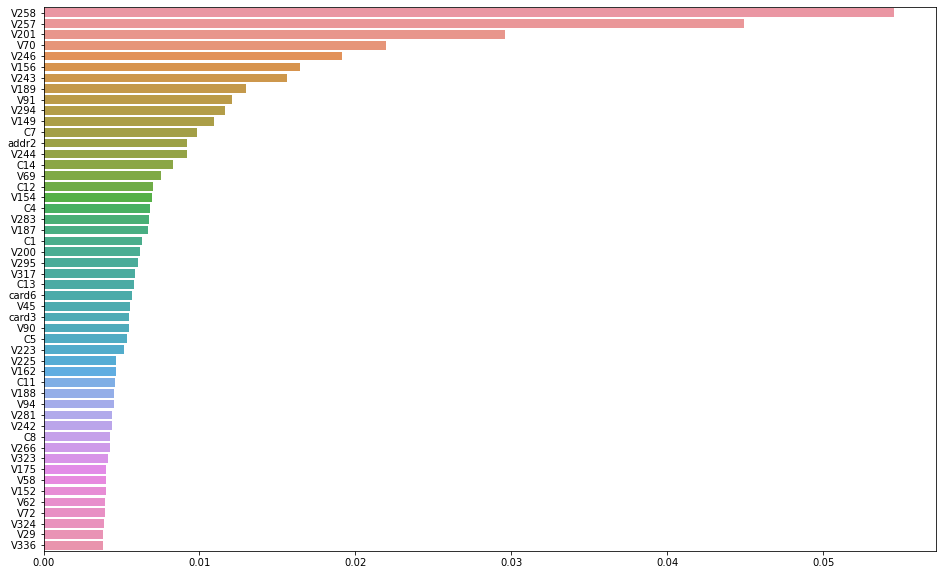

In [11]:
##### Feature Importance

features_importance = clf.feature_importances_
   
features_array = np.array(feature_list)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y=features_array, x=features_importance, orient='h', order=features_array_ordered[:50])
plt.show()

In [12]:
##### Saving this results into an Excel file

params = clf.get_params()

try:
    model_results = pd.read_excel('model_results.xlsx')
    
    model_results = model_results.append({'datetime' : datetime.datetime.now(), 'clf':clf.__class__, 'features': feature_list, 'parameters' : params,
                                       'AUC': auc, 'features_importance': list(features_importance), 'features_ordered': list(features_array_ordered), 
                                       'r_curve': list(r_curve)}, ignore_index=True)
        
except:
    model_results = pd.DataFrame(columns = ['summary', 'datetime', 'clf', 'features', 'parameters', 'entry1', 'entry2', 
                                            'AUC', 'features_importance', 'features_ordered', 'r_curve', 'output2'])
    
    model_results = model_results.append({'datetime' : datetime.datetime.now(), 'clf':clf.__class__, 'features': feature_list, 'parameters' : params, 
                                       'AUC': auc, 'features_importance': list(features_importance), 'features_ordered': list(features_array_ordered),
                                       'r_curve': list(r_curve)}, ignore_index=True)
finally:
    model_results.to_excel('model_results.xlsx')

In [13]:
##### Saving this model

joblib.dump(clf, 'model_xgboost.pkl')

['model_xgboost.pkl']

# Submission to Kaggle

In [14]:
y_pred_submission = clf.predict_proba(test[feature_list])[:,1]
print (y_pred_submission)

df_submission = pd.DataFrame({'TransactionID': test.TransactionID, 'isFraud': y_pred_submission})
df_submission
df_submission.to_csv('submission.csv', index=False)

[0.00282973 0.00385214 0.00505377 ... 0.00544613 0.01398421 0.03301749]


In [15]:
df_val.to_pickle('val_xgb.pkl')
print('Done!')

Done!
